In [2]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
#from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance
from scipy.stats import norm

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.callbacks import Points, InputDeviceState
from ipywidgets import interact

import json
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 16})

# Runaway Data Processing
Processing the data from our runaway drone incident, 04/14/2021.

This file brings in data from all available data streams:
 - The new GPS logs
 - The DJI logs
 - The UGCS logs

20002
Index(['iTOW', 'UTC', 'tAcc', 'Lon', 'Lat', 'Height', 'HMSL', 'hAcc', 'vAcc',
       'pDOP', 'numSV', 'velN', 'velE', 'velD', 'gspeed', 'headmot', 'sAcc',
       'headAcc', 'fixType', 'fixOK', 'UTCvalid', 'HPvalid', 'carrierSoln',
       'diffCorrected', 'pitch', 'roll', 'yaw'],
      dtype='object')
0 days 00:00:00.200000


(41.320605476, 41.337122498)

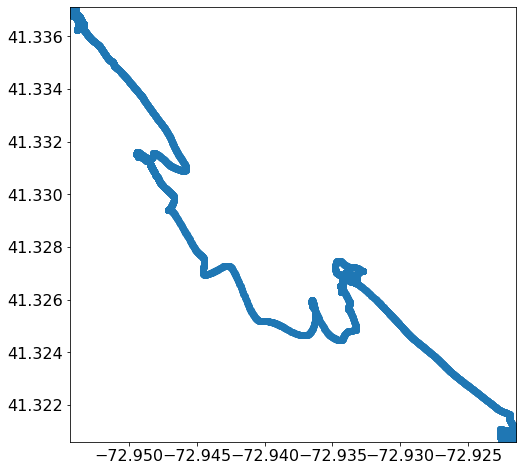

In [3]:
# Load the uBlox data

# read the first file
df = pd.read_csv("./04142053",sep=",",header=0)

# read the second file
new_df = pd.read_csv("./04142126",sep=',', header=0)

# glue them together and reindex
df = pd.concat([df, new_df], axis=0, join='inner')
df.reset_index(drop=True, inplace=True)

# turn the timestamp strings into proper numpy datetime objects
ubx_df = df.assign(UTC = pd.to_datetime(df.UTC))

print(len(ubx_df))
print(ubx_df.columns)
print(ubx_df['UTC'][1]-ubx_df['UTC'][0])

# make a quick scatter plot
fig = plt.figure()
plt.scatter(ubx_df.Lon, ubx_df.Lat)
plt.xlim(min(ubx_df.Lon), max(ubx_df.Lon))
plt.ylim(min(ubx_df.Lat), max(ubx_df.Lat))

In [4]:
# Load the DJI data

dji_df = pd.read_csv("./FLY397_10hz_withevents.csv", sep=',', header=0)

print(dji_df.columns)
print(len(dji_df))

for col in dji_df.columns: print(col)

# different timestamp interpolation method than usual
# (the normal one broke because it relied on having the GPS dateTimeStamp)
# note that the indices here only apply to this specific file

# offsetTime turnover seems to happen at 3953/3954
# 3961 is the nearest index to the offsetTime turnover where the GPS dateTimeStamp ticks over
start_dt = pd.to_datetime(dji_df["GPS:dateTimeStamp"][3961])
print(start_dt)

offsets = np.array(dji_df["offsetTime"]-dji_df["offsetTime"][3961])
offsets = pd.to_timedelta(offsets, unit='s')

timestamps = start_dt + offsets

dji_df = dji_df.assign(timestamp = timestamps)
dji_df = dji_df.assign(UTC = timestamps)

/home/annie/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (50,65,80,105,106,117,118,119,120,121,122,123,124,125,126,266,268,270,271,272,307,332) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['Tick#', 'offsetTime', 'IMU_ATTI(0):Longitude', 'IMU_ATTI(0):Latitude',
       'IMU_ATTI(0):numSats', 'IMU_ATTI(0):barometer:Raw',
       'IMU_ATTI(0):barometer:Smooth', 'IMU_ATTI(0):accel:X',
       'IMU_ATTI(0):accel:Y', 'IMU_ATTI(0):accel:Z',
       ...
       'RTKdata:posFlg_0', 'RTKdata:posFlg_1', 'RTKdata:posFlg_2',
       'RTKdata:posFlg_3', 'RTKdata:posFlg_4', 'RTKdata:posFlg_5',
       'RTKdata:GpsState', 'Attribute|Value', 'ConvertDatV3', '3.7.6'],
      dtype='object', length=335)
20958
Tick#
offsetTime
IMU_ATTI(0):Longitude
IMU_ATTI(0):Latitude
IMU_ATTI(0):numSats
IMU_ATTI(0):barometer:Raw
IMU_ATTI(0):barometer:Smooth
IMU_ATTI(0):accel:X
IMU_ATTI(0):accel:Y
IMU_ATTI(0):accel:Z
IMU_ATTI(0):accel:Composite
IMU_ATTI(0):gyro:X
IMU_ATTI(0):gyro:Y
IMU_ATTI(0):gyro:Z
IMU_ATTI(0):gyro:Composite
IMU_ATTI(0):mag:X
IMU_ATTI(0):mag:Y
IMU_ATTI(0):mag:Z
IMU_ATTI(0):mag:Mod
IMU_ATTI(0):velN
IMU_ATTI(0):velE
IMU_ATTI(0):velD
IMU_ATTI(0):velComposite
IMU_ATTI(0):velH
IMU_ATTI(0):roll

In [5]:
# Load the UGCS data

ugcs_df = pd.read_csv("./UGCS/M600-0670139951 4_14_2021 4_38_35 PM (34_04).csv",sep=",",header=0)
ugcs_df = ugcs_df.assign(time = pd.to_datetime(ugcs_df.time).dt.tz_localize('America/New_York'))
ugcs_df = ugcs_df.assign(UTC = ugcs_df.time.dt.tz_convert('UTC'))
print(ugcs_df.columns)
print(len(ugcs_df))
print(ugcs_df['time'][1000]-ugcs_df['time'][999])
print(ugcs_df['UTC'])

Index(['time', 'is_armed', 'rc_latitude', 'vertical_speed', 'gcs_link_quality',
       'rc_altitude_agl', 'target_latitude', 'pitch', 'heading',
       'satellite_count', 'target_altitude_amsl', 'roll', 'rc_link_quality',
       'target_longitude', 'main_current', 'autopilot_status', 'rc_longitude',
       'altitude_raw', 'takeoff_latitude', 'current_mission_id', 'flight_mode',
       'ground_speed', 'takeoff_longitude', 'current_command', 'gps_fix',
       'remaining_power_level', 'longitude', 'uplink_present', 'latitude',
       'control_mode', 'course', 'home_longitude', 'downlink_present',
       'main_voltage', 'home_latitude', 'gimbal:pitch', 'gimbal:roll',
       'gimbal:heading', 'gpr:gpr_vs_gnss_health', 'gpr:gpr_vs_flight_mode',
       'gpr:gpr_vs_pitch', 'gpr:gpr_gs_free_space', 'gpr:gpr_vs_error_code',
       'gpr:gpr_vs_display_mode', 'gpr:gpr_trace', 'gpr:gpr_vs_yaw',
       'gpr:gpr_text', 'gpr:gpr_vs_longitude', 'gpr:gpr_gs_enabled',
       'gpr:gpr_vs_altitude', 'gpr:g

/home/annie/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,27,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
print(ugcs_df["control_server:log"])
# make errors show up as vertical lines on other plots?

0                          [NOTICE] Home location cleared
1       [NOTICE] New home location: 41°19′15.23″N, 72°...
2       [NOTICE] New home location: 41°19′15.23″N, 72°...
3       [NOTICE] New home location: 41°19′15.23″N, 72°...
4       [NOTICE] New home location: 41°19′15.23″N, 72°...
                              ...                        
9925    [ERROR] Manual Mode - Command failed. Already ...
9926    [ERROR] Manual Mode - Command failed. Already ...
9927    [ERROR] Manual Mode - Command failed. Already ...
9928    [ERROR] Manual Mode - Command failed. Already ...
9929    [ERROR] Manual Mode - Command failed. Already ...
Name: control_server:log, Length: 9930, dtype: object


In [150]:
# trim the data files to the start of the DJI file
print(dji_df["UTC"][0])
print(ubx_df["UTC"][0])
print(ugcs_df["UTC"][0])

ubx_df = ubx_df.loc[ubx_df["UTC"] >= dji_df["UTC"][0]].reset_index(drop=True)
print(dji_df["UTC"][0])

ugcs_df = ugcs_df.loc[ugcs_df["UTC"] >= dji_df["UTC"][0]].reset_index(drop=True)

print(ubx_df.UTC)
print(ugcs_df.UTC)

# trim the end of the UBX file to the end of the DJI file (the UGCS file is already shorter)
print(dji_df["UTC"].values[-1])
print(ubx_df["UTC"].values[-1])
print(ugcs_df["UTC"].values[-1])

ubx_df = ubx_df.loc[ubx_df["UTC"] <= pd.to_datetime(dji_df["UTC"].values[-1]).tz_localize("UTC")].reset_index(drop=True)

2021-04-14 20:57:43.503000+00:00
2021-04-14 20:57:43.600154+00:00
2021-04-14 20:57:59.137000+00:00
2021-04-14 20:57:43.503000+00:00
0       2021-04-14 20:57:43.600154+00:00
1       2021-04-14 20:57:43.800153+00:00
2       2021-04-14 20:57:44.000153+00:00
3       2021-04-14 20:57:44.200153+00:00
4       2021-04-14 20:57:44.400153+00:00
                      ...               
10647   2021-04-14 21:33:15.000048+00:00
10648   2021-04-14 21:33:15.200048+00:00
10649   2021-04-14 21:33:15.400048+00:00
10650   2021-04-14 21:33:15.600048+00:00
10651   2021-04-14 21:33:15.800047+00:00
Name: UTC, Length: 10652, dtype: datetime64[ns, UTC]
0      2021-04-14 20:57:59.137000+00:00
1      2021-04-14 20:57:59.241000+00:00
2      2021-04-14 20:57:59.437000+00:00
3      2021-04-14 20:57:59.638000+00:00
4      2021-04-14 20:57:59.840000+00:00
                     ...               
4523   2021-04-14 21:12:38.049000+00:00
4524   2021-04-14 21:12:38.049000+00:00
4525   2021-04-14 21:12:38.094000+00:00
4526

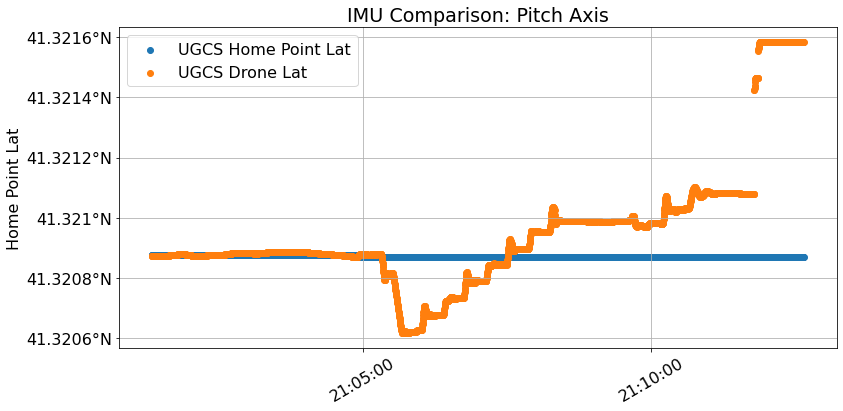

In [315]:
# Plot a variable over time
# This time I picked Latitude, but the process is the same for any of them

fig = plt.figure(figsize=(12,6))
ax = plt.gca()

# Format the timestamp on the x axis as HH:MM:SS
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()

# Uncomment this line to format a latitude axis
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)

# Uncomment this line to format a longitude axis 
#ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)

trim_start = 1700
trim_stop = 3500
plt.scatter(ugcs_df.UTC[1000:], ugcs_df.home_latitude[1000:], label="UGCS Home Point Lat")
plt.scatter(ugcs_df.UTC[1000:], ugcs_df.latitude[1000:], label="UGCS Drone Lat")
plt.grid()
plt.xticks(rotation=30)
plt.ylabel("Home Point Lat")
plt.title("IMU Comparison: Pitch Axis")
plt.legend()
plt.tight_layout()
plt.show()

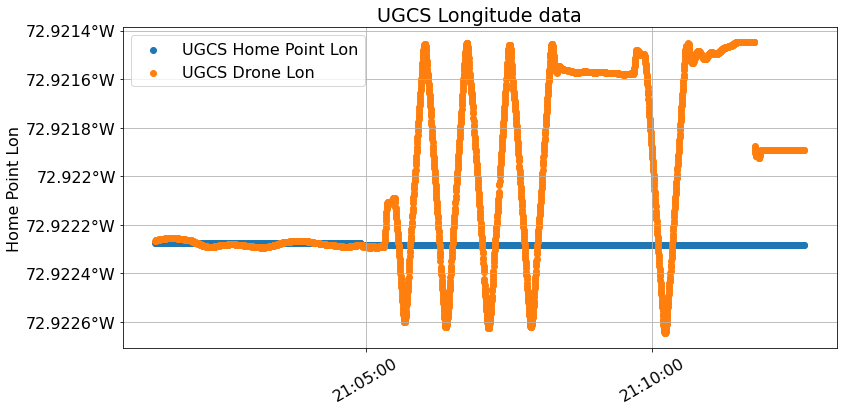

In [320]:
# Plot a variable over time
# This time I picked Latitude, but the process is the same for any of them

fig = plt.figure(figsize=(12,6))
ax = plt.gca()

# Format the timestamp on the x axis as HH:MM:SS
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()

# Uncomment this line to format a latitude axis
#ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)

# Uncomment this line to format a longitude axis 
ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)

plt.scatter(ugcs_df.UTC[1000:], ugcs_df.home_longitude[1000:], label="UGCS Home Point Lon")
plt.scatter(ugcs_df.UTC[1000:], ugcs_df.longitude[1000:], label="UGCS Drone Lon")
plt.grid()
plt.xticks(rotation=30)
plt.ylabel("Home Point Lon")
plt.title("UGCS Longitude data")
plt.legend()
plt.tight_layout()
plt.show()

## Column descriptions
* **iTOW**: GPS time of week in milliseconds
* **UTC**: UTC timestamp
* **tAcc**: Time accuracy estimate in nanoseconds
* **Lon**: Longitude in decimal degrees
* **Lat**: Latitude in decimal degrees
* **Height**: Height above the WGS84 ellipsoid in meters
* **HMSL**: Height above mean sea level in meters
* **hAcc**: Horizontal accuracy estimate in millimeters
* **vAcc**: Vertical accuracy estimate in millimeters
* **pDOP**: Position dilution of precision * 100 (unitless measurement of the quality of the current arrangement of satellites overhead)
* **numSV**: Number of satellites currently connected
* **velN, velE, velD**: Velocity in mm/s in NED coordinates
* **gspeed**: 2D ground speed in m/s
* **headmot**: Heading of motion (note that this is from GPS only, not an IMU, and is not very accurate)
* **sAcc**: Speed accuracy estimate in mm/s
* **headAcc**: Heading accuracy estimate in degrees
* **fixType**: 0 for no fix, 1 for dead-reckoning, 2 for 2D fix, 3 for 3D fix, 4 for GNSS+dead reckoning, 5 for time-only. The ideal value is 3.
* **fixOK**: 1 if the fix is "OK", 0 if not. 
* **UTCvalid**: 1 if the time and date are confirmed to be correct, 0 if not
* **HPvalid**: 1 if the high precision fix if "OK", 0 if not
* **carrierSoln**: 2 if carrier phase ambiguities are fixed, 1 if they're floating, 0 if not corrected. 2 is ideal.
* **diffCorrected**: 1 if differential corrections have been applied, 0 if not

## Plots

0       2021-04-14 20:57:43.600154+00:00
1       2021-04-14 20:57:43.800153+00:00
2       2021-04-14 20:57:44.000153+00:00
3       2021-04-14 20:57:44.200153+00:00
4       2021-04-14 20:57:44.400153+00:00
                      ...               
10647   2021-04-14 21:33:15.000048+00:00
10648   2021-04-14 21:33:15.200048+00:00
10649   2021-04-14 21:33:15.400048+00:00
10650   2021-04-14 21:33:15.600048+00:00
10651   2021-04-14 21:33:15.800047+00:00
Name: UTC, Length: 10652, dtype: datetime64[ns, UTC]


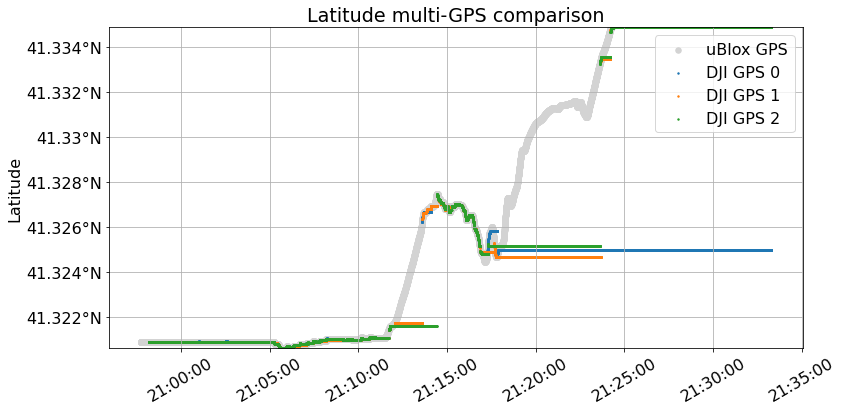

In [312]:
# Plot a variable over time
# This time I picked Latitude, but the process is the same for any of them

fig = plt.figure(figsize=(12,6))
ax = plt.gca()

# Format the timestamp on the x axis as HH:MM:SS
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()

# Uncomment this line to format a latitude axis
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)

# Uncomment this line to format a longitude axis 
#ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)

plt.scatter(ubx_df.UTC, ubx_df.Lat, label="uBlox GPS", s=30, c='lightgrey')
plt.scatter(dji_df.UTC, dji_df["IMU_ATTI(0):Latitude"], label="DJI GPS 0", s=2)
plt.scatter(dji_df.UTC, dji_df["IMU_ATTI(1):Latitude"], label="DJI GPS 1", s=2)
plt.scatter(dji_df.UTC, dji_df["IMU_ATTI(2):Latitude"], label="DJI GPS 2", s=2)

print(ubx_df.UTC)

plt.grid()
#plt.xlim(np.datetime64("2021-04-14 21:05"), np.datetime64("2021-04-14 21:20"))
plt.ylim(min(dji_df["IMU_ATTI(2):Latitude"].dropna()), max(dji_df["IMU_ATTI(2):Latitude"].dropna()))
plt.xticks(rotation=30)
plt.ylabel("Latitude")
plt.title("Latitude multi-GPS comparison")
plt.legend()
plt.tight_layout()
plt.savefig("lats.jpg")
plt.show()

<Figure size 1440x1152 with 0 Axes>

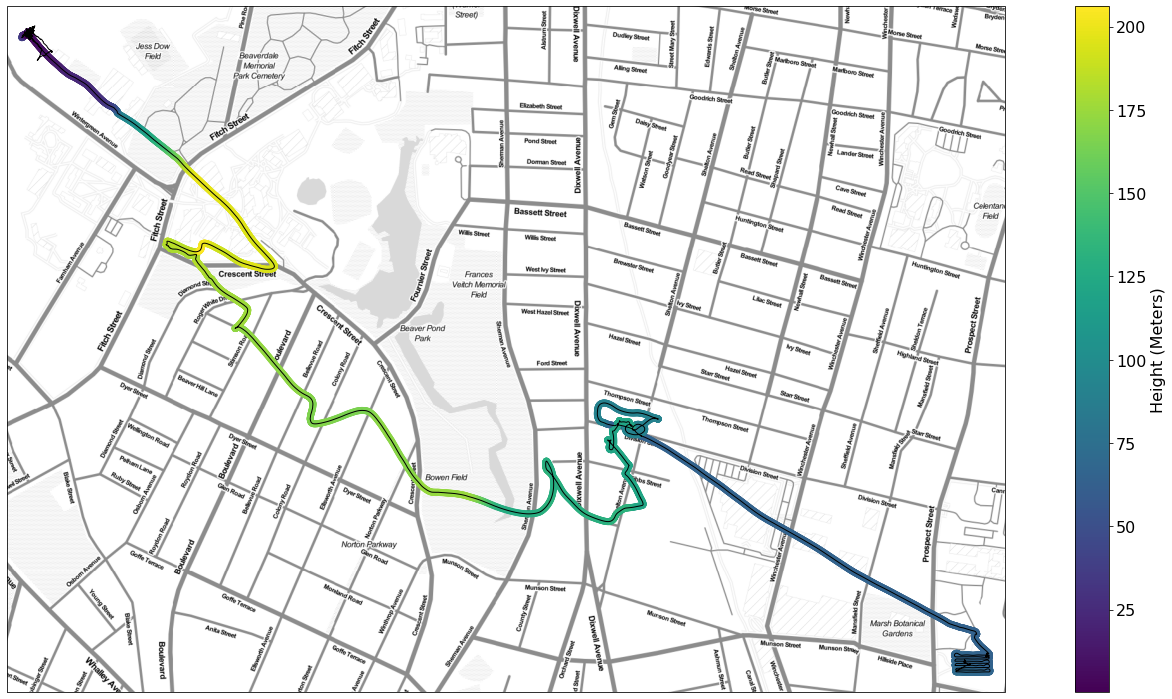

In [76]:
# Visualize the flag columns by conditionally coloring the plot
fig = plt.figure(figsize=(20, 16))

PLOT_BG = cimgt.Stamen('toner-lite')
mercator = PLOT_BG.crs

BORDER = 0.0005

fig = plt.figure(figsize=(20,10))

plain_crs = ccrs.PlateCarree()

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=mercator) 

# set the extents of the plot to be a box around the data
ax.set_extent([min(ubx_df.Lon)-BORDER, max(ubx_df.Lon)+BORDER, min(ubx_df.Lat)-BORDER, max(ubx_df.Lat)+BORDER], crs=plain_crs)

# use cartopy to add a satellite map to the background
#ax.add_image(PLOT_BG, 20, interpolation='spline36')
ax.add_image(PLOT_BG, 16)

# plot the data, transformed into the coordinate system of our plot
plt.plot(ubx_df.Lon, ubx_df.Lat, 'c', linewidth=1, transform=plain_crs, color='black')

tstart = 3000
tstop = 10000
alts = plt.scatter(ubx_df.Lon[tstart:tstop], ubx_df.Lat[tstart:tstop], c=ubx_df.Height[tstart:tstop], transform=plain_crs)
# mark where we gave up
#plt.scatter(df.Lon[8542], df.Lat[8542], transform=plain_crs, marker="x", c="red", s=500)

# label and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
fig.colorbar(alts, label="Height (Meters)")
plt.tight_layout()
plt.savefig("alt_track.png")
plt.show()


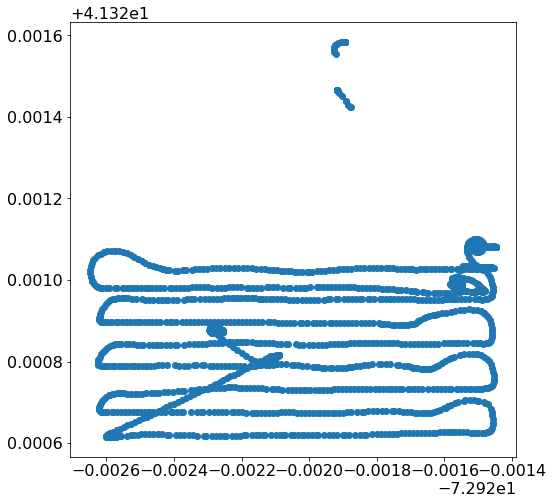

2021-04-14T21:00:00.017000000


In [211]:
# make a quick scatter plot
fig = plt.figure()
plt.scatter(ugcs_df.longitude[6000:], ugcs_df.latitude[6000:])
plt.show()

print(ugcs_df['time'].values[6000])

In [319]:
# Plotly-based multi-row plotter
# Visualizes time-series data as a stacked set of subplots with a shared mouseover line

# plot layout adjustments
sp_height = 250 # height of each subplot
sp_width = 1000 # width of the plots
v_space = 0.05 # spacing between subplots
share_yrange = False # whether or not to have all subplots share a Y axis range
# only set this to true if you're plotting several copies of the same type of column

# plot data arrays
# format for each subplot is [X_axis, Y_axis, "name"]
# mixing data from all 3 dataframes is allowed, just make sure the X and Y axes match within each subplot
# remember to comment out the ones you're not using to save memory

# a generic test set
title = "Generic test data set"
to_plot = [
    [ubx_df.UTC, ubx_df.Lat, "UBX lat"],
    [ubx_df.UTC, ubx_df.Lon, "UBX lon"],
    [dji_df.UTC, dji_df['IMU_ATTI(0):numSats'], "DJI numSV"],
    [ugcs_df.UTC, ugcs_df.rc_link_quality, "UGCS RC link quality"]
]

# (almost) every latitude field I could find
# title = "Many Latitudes"
# to_plot = [
#     [ubx_df.UTC, ubx_df.Lat, "UBX"],
#     [dji_df.UTC, dji_df["IMU_ATTI(0):Latitude"], "DJI IMU0"],
#     [dji_df.UTC, dji_df["GPS(0):Lat"], "DJI GPS0"],
# ]


# magic plotter loop

# https://github.com/jonmmease/plotly_ipywidget_notebooks/blob/master/notebooks/Interact.ipynb for interaction
fig = go.FigureWidget(make_subplots(rows=len(to_plot), cols=1, shared_xaxes=True, vertical_spacing = v_space))

for i in range(len(to_plot)):
    fig.add_trace(
        go.Scatter(x=to_plot[i][0], y=to_plot[i][1], name=to_plot[i][2]),
        row=i+1, col=1
    )

print(fig)
    
fig.update_traces(xaxis="x"+str(len(to_plot)), cliponaxis=False)
fig.update_yaxes(showspikes=False, fixedrange=True)
fig.update_xaxes(showspikes=True, spikemode="across", range=[min(ubx_df.UTC),max(ubx_df.UTC)],
                rangeslider=dict(autorange=True, range=[min(ubx_df.UTC),max(ubx_df.UTC)]))
fig.update_layout(height=subplot_height*len(to_plot), width=sp_width, margin={'pad':10},
                  title_text=title, spikedistance=10000, hoverdistance=10000)

fig.update_yaxes(row=2,range=list([41.32, 41.34]))

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(
        figure=fig,
        id='stack-graph'
    ),
    
    html.Div(className='row', children=[
        html.Div([
            dcc.Markdown("""
                **Zoom and Relayout Data**

                Click and drag on the graph to zoom or click on the zoom
                buttons in the graph's menu bar.
                Clicking on legend items will also fire
                this event.
            """),
            html.Pre(id='relayout-data'),
        ], className='three columns')
    ])
])

@app.callback(
    Output('relayout-data', 'children'),
    Input('stack-graph', 'relayoutData'))
def display_relayout_data(relayoutData):
    #print("relay")
    return json.dumps(relayoutData, indent=2)

cur_x_min = min(ubx_df.UTC)
cur_x_max = max(ubx_df.UTC)
print(cur_x_min)
foo_ax_name = "xaxis"+str(len(to_plot))

def set_x_bounds(new_x_val):
    cur_x_min = new_x_val[0]
    cur_x_max = new_x_val[1]

@app.callback(
    Output('stack-graph', 'figure'),
    Input('stack-graph', 'relayoutData'))
def update_y_range(relayoutData):
    # range adjustment callback for autoscaling the Y axes
    if (relayoutData == None): return fig # avoids a startup error
    #print(relayoutData)
    print(cur_x_min)
    # see if we got x axis range data
    if (foo_ax_name+".range" in relayoutData):
        print("found axis")
        new_x = np.array(pd.to_datetime(relayoutData[ax_name+".range"], utc=True))
        print(new_x)
        # check if the axes have actually changed
        if (cur_x_min != new_x[0] or cur_x_max != new_x[1]):
            print("axes have changed")
            set_x_bounds(new_x) # use a setter function bc callbacks have weird scope
            
            # find the new y bounds for each plot
            for i in range(len(to_plot)):
                mask = to_plot[i][0]
                print(type(mask))
            
            
        else:
            print("no axis change")
        
    return fig

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

FigureWidget({
    'data': [{'name': 'UBX lat',
              'type': 'scatter',
              'uid': '9194e76f-7e5a-4478-a614-534cb0c53884',
              'x': array([datetime.datetime(2021, 4, 14, 20, 57, 43, 600154, tzinfo=<UTC>),
                          datetime.datetime(2021, 4, 14, 20, 57, 43, 800153, tzinfo=<UTC>),
                          datetime.datetime(2021, 4, 14, 20, 57, 44, 153, tzinfo=<UTC>), ...,
                          datetime.datetime(2021, 4, 14, 21, 33, 15, 400048, tzinfo=<UTC>),
                          datetime.datetime(2021, 4, 14, 21, 33, 15, 600048, tzinfo=<UTC>),
                          datetime.datetime(2021, 4, 14, 21, 33, 15, 800047, tzinfo=<UTC>)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([41.3208844 , 41.32088443, 41.32088436, ..., 41.33696898, 41.33696988,
                          41.33697118]),
              'yaxis': 'y'},
             {'name': 'UBX lon',
              'type': 'scatter',
   

In [245]:
app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(
        figure=fig,
        id='stack-graph'
    ),
    
    html.Div(className='row', children=[
        html.Div([
            dcc.Markdown("""
                **Zoom and Relayout Data**

                Click and drag on the graph to zoom or click on the zoom
                buttons in the graph's menu bar.
                Clicking on legend items will also fire
                this event.
            """),
            html.Pre(id='relayout-data'),
        ], className='three columns')
    ])
])

@app.callback(
    Output('relayout-data', 'children'),
    Input('stack-graph', 'relayoutData'))
def display_relayout_data(relayoutData):
    print("relay")
    return json.dumps(relayoutData, indent=2)

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
relay
relay
relay
relay
relay
relay
relay
relay
relay
relay
relay
relay


In [237]:
app = dash.Dash()

df = pd.DataFrame({
    "x": [1,2,1,2],
    "y": [1,2,3,4],
    "customdata": [1,2,3,4],
    "fruit": ["apple", "apple", "orange", "orange"]
})

fig = px.scatter(df, x="x", y="y", color="fruit", custom_data=["customdata"])

fig.update_layout(clickmode='event+select')

fig.update_traces(marker_size=20)

app.layout = html.Div([
    dcc.Graph(
        id='basic-interactions',
        figure=fig
    ),

    html.Div(className='row', children=[
        html.Div([
            dcc.Markdown("""
                **Zoom and Relayout Data**

                Click and drag on the graph to zoom or click on the zoom
                buttons in the graph's menu bar.
                Clicking on legend items will also fire
                this event.
            """),
            html.Pre(id='relayout-data'),
        ], className='three columns')
    ])
])

@app.callback(
    Output('relayout-data', 'children'),
    Input('basic-interactions', 'relayoutData'))
def display_relayout_data(relayoutData):
    return json.dumps(relayoutData, indent=2)

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [213]:
np.random.seed(1)

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


scatter.on_hover(update_point)

print(scatter)
print(type(scatter))

f

Scatter({
    'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                         #a3a7e4, #a3a7e4,

FigureWidget({
    'data': [{'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
               …